In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

## data load

In [2]:
gpu_id = 2
num_cores = 4
torch.cuda.set_device(gpu_id)

In [3]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets
/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss


In [4]:
bs=8
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [5]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [6]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [7]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


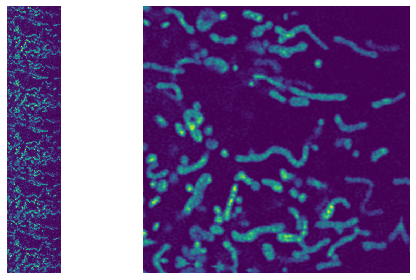

In [8]:
data.show_batch(rows=1)

## feature loss

In [9]:
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/')

In [10]:
critic = load_learner(path=critic_pth/'critics',file='critic_fluorescence_single.2a.pkl')

In [11]:
encoder = critic.model.eval()[0]
layers, layer_ind = pooling_layer(encoder)
act_blocks = previous_layer(layer_ind)
feat_loss = FeatureLoss(m_feat=encoder, layer_ids=act_blocks, layer_wgts=[1/6 for _ in range(6)])

In [12]:
layers

[Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)]

## training

In [13]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

## in-painting loss

In [14]:
save_name = 'fluo_inpainting_100epoch'

In [15]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                           loss_func=feat_loss, metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [16]:
learn.fit_one_cycle(cycles, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,time
0,1.348633,1.805417,25.164820,0.150537,0.337571,0.072267,0.041283,0.089711,0.054134,0.137019,0.066656,0.552873,0.055455,0.210879,0.025850,0.146696,0.015023,08:18
1,1.229388,1.816373,25.118732,0.161885,0.345525,0.071953,0.041204,0.089589,0.054084,0.137195,0.066792,0.562262,0.056520,0.209741,0.026018,0.140548,0.014943,08:25
2,1.186869,1.649062,25.573036,0.176929,0.322409,0.068074,0.039177,0.086416,0.052428,0.135125,0.065975,0.484995,0.048822,0.181073,0.022973,0.127605,0.013990,08:33
3,1.171099,1.592817,25.724310,0.186099,0.310200,0.065407,0.037807,0.084023,0.051090,0.132704,0.064964,0.467053,0.046504,0.171678,0.021937,0.125843,0.013607,08:29
4,1.161231,1.588928,25.847078,0.193300,0.306803,0.063602,0.036778,0.081879,0.049870,0.130202,0.063834,0.470851,0.046704,0.175412,0.022022,0.127403,0.013567,08:18
5,1.095656,1.487218,26.217661,0.203532,0.291528,0.062132,0.036120,0.081067,0.049489,0.129992,0.063782,0.417108,0.041538,0.159177,0.020581,0.121502,0.013202,08:15
6,1.071949,1.634960,26.051580,0.201531,0.298751,0.062333,0.036061,0.080813,0.049255,0.129333,0.063411,0.490173,0.048424,0.193892,0.023627,0.144453,0.014433,08:16
7,1.107120,1.508801,26.175135,0.210318,0.294298,0.062108,0.036018,0.081052,0.049512,0.130418,0.063967,0.425932,0.042614,0.164827,0.020978,0.123640,0.013437,08:16
8,1.057013,1.570025,25.877695,0.205284,0.303244,0.063075,0.036554,0.081668,0.049782,0.130523,0.064012,0.459397,0.046370,0.172108,0.021839,0.127828,0.013625,08:15
9,1.055404,1.535486,25.982122,0.213796,0.299760,0.063482,0.036812,0.082184,0.050134,0.131360,0.064403,0.448577,0.045056,0.161211,0.020934,0.118356,0.013217,08:18


PermissionError: Caught PermissionError in DataLoader worker process 5.
Original Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "../../model/bpho/multi.py", line 136, in open
    img_data = np.load(fn)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/numpy/lib/npyio.py", line 422, in load
    fid = open(os_fspath(file), "rb")
PermissionError: [Errno 13] Permission denied: '/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5/train/mitotracker/mitotracker_PSSR-MF_train_lr_1463.npy'


In [21]:
learn.validate()

[1.3445343, tensor(27.1166), tensor(0.2494)]

In [22]:
learn.fit_one_cycle(cycles-48, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,time
0,0.830410,1.301019,27.275524,0.252517,0.254236,0.054268,0.031802,0.073172,0.045084,0.122321,0.060423,0.339518,0.033772,0.140560,0.018243,0.115142,0.012477,08:24
1,0.833969,1.289084,27.334978,0.254798,0.252133,0.054143,0.031739,0.073089,0.045044,0.122266,0.060409,0.333201,0.033047,0.138636,0.018083,0.114853,0.012442,08:39
2,0.850712,1.221285,27.403864,0.256740,0.250605,0.054521,0.031941,0.073464,0.045298,0.122761,0.060650,0.294601,0.029831,0.124309,0.016819,0.104517,0.011969,08:43
3,0.858104,1.247030,27.350908,0.254736,0.252141,0.054479,0.031925,0.073415,0.045253,0.122666,0.060585,0.307635,0.030989,0.129691,0.017239,0.108853,0.012158,08:32
4,0.837083,1.248379,27.432945,0.258621,0.249977,0.054236,0.031804,0.073235,0.045156,0.122519,0.060532,0.308459,0.031288,0.130890,0.017485,0.110529,0.012269,08:29
5,0.849699,1.244714,27.370913,0.254918,0.250831,0.054266,0.031782,0.073131,0.045085,0.122335,0.060440,0.311462,0.031001,0.128757,0.017028,0.106618,0.011979,08:28
6,0.852623,1.204302,27.326468,0.255446,0.252481,0.055051,0.032230,0.074059,0.045646,0.123553,0.060981,0.277725,0.028983,0.121023,0.016689,0.103800,0.012082,08:27
7,0.838953,1.398571,27.046175,0.247512,0.260814,0.055187,0.032243,0.073839,0.045406,0.122686,0.060552,0.393905,0.037989,0.157540,0.019715,0.125771,0.012923,08:31
8,0.845053,1.270442,27.146936,0.255506,0.259802,0.055172,0.032270,0.074054,0.045621,0.123508,0.060939,0.320686,0.032963,0.131050,0.017555,0.104739,0.012082,08:28
9,0.885361,1.197659,27.190083,0.252156,0.257260,0.056239,0.032882,0.075339,0.046338,0.124984,0.061594,0.272309,0.028509,0.115423,0.016345,0.098500,0.011937,08:28


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in

    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):

  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child p

    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionE

  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a0ab5400>
Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocess

  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
AssertionError: can only join a child process
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    self._shutdown_workers()
    w.join()
    w.join()
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    w.join()
AssertionError: can 

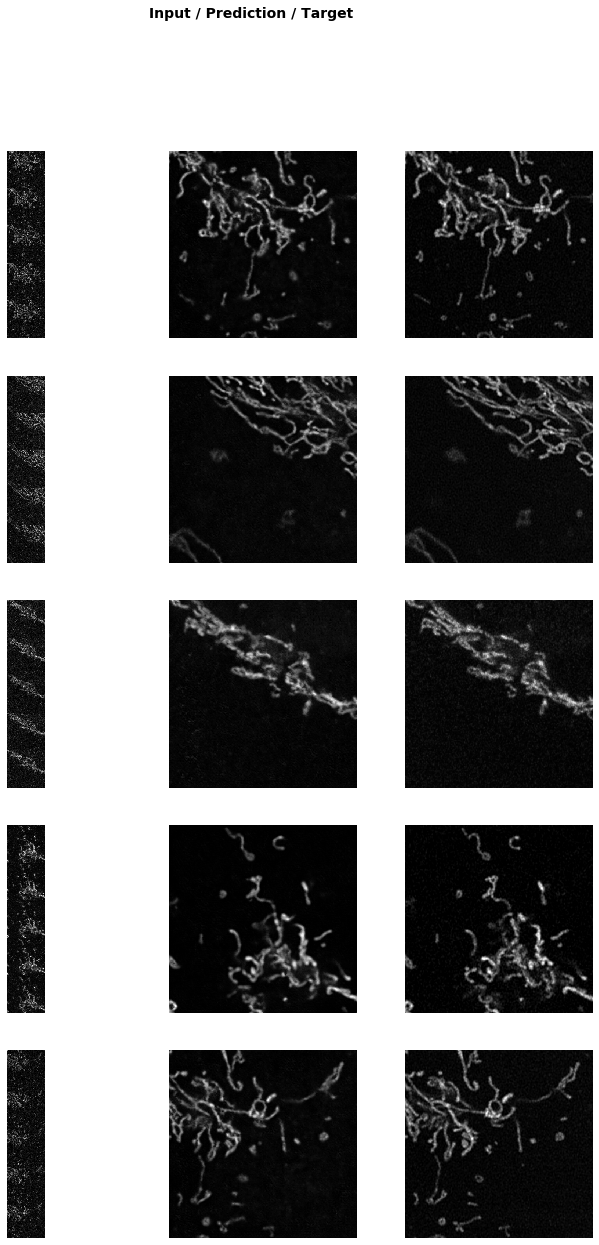

In [23]:
learn.show_results(rows=5, cmap='gray')

In [24]:
learn.save(save_name)
print(f'saved: {save_name}')

saved: fluo_inpainting_100epoch
